# <span style="color:black; font-weight:bold;">Stereo seq testicles data Tutorial</span>
#### • <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
#### • <span style="color:black; font-weight:bold;">Date of Creation</span>: 10.10.2025
#### • <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 10.10.2025
#### • <span style="color:black; font-weight:bold;">Download</span>: Stereo-seq testicles data used in the tutorial is available at [testis.h5ad](https://drive.google.com/open?id=1li92sr3lFebNXjuAP1YOwMZzlKSOA66z&usp=drive_fs)
In this tutorial we apply SpaLP to Stereo-seq testicles data from [STOmics](https://www.stomics.tech/col1367)

<span style="color:black; font-weight:bold;">The dataset have:</span>   
• <span style="color:black; font-weight:bold;">Stereo-seq testicles data</span>: 198,248 cells and 27,869 genes 

In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.RandLA import SpatialAutoencoder
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

## <span style="color:black; font-weight:bold;">Loading testicles data</span>

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLA/stereoseqmousegaowan/testis.h5ad')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 198248 × 27869
    obs: 'dnbCount', 'area', 'id', 'orig.ident', 'x', 'y'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn'
    obsm: 'cell_border', 'spatial'

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to select top5000 HVGs and perform standard data processing.  
The standard processed expression matrix was saved in adata.obsm[<span style="color:red;">'feat'</span>] and used as input to the model.

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000, flavor='seurat_v3')
adata = adata[:,adata.var.highly_variable]
sc.pp.normalize_total(adata, target_sum=1e4,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat'] = adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the spatial Graph using 4 neighbors in simulated data. k=4

In [7]:
k=4
graph = prepare_inputs(adata, k, device)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 50, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [8]:
in_channels = graph.features.shape[1]
model = SpatialAutoencoder(in_channels, out_channels=50).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.03it/s, Epoch=199, Loss=0.9882]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed gene expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed gene expression is constructed as adata2

In [10]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding

In [11]:
adata.obsm['SpaLP']=embedding

### Reconstructed gene expression

In [12]:
adata2=sc.AnnData(reconstructed)
adata2.obs=adata.obs
adata2.var=adata.var
adata2.uns=adata.uns
adata2.obsm=adata.obsm

## <span style="color:black; font-weight:bold;">Identify Niches</span>
We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches.

In [13]:
sc.pp.neighbors(adata, use_rep='SpaLP')

In [14]:
sc.tl.leiden(adata, random_state=2024, resolution=1.2,key_added='SpaLP')

## <span style="color:black; font-weight:bold;">Niche identified by SpaLP</span>

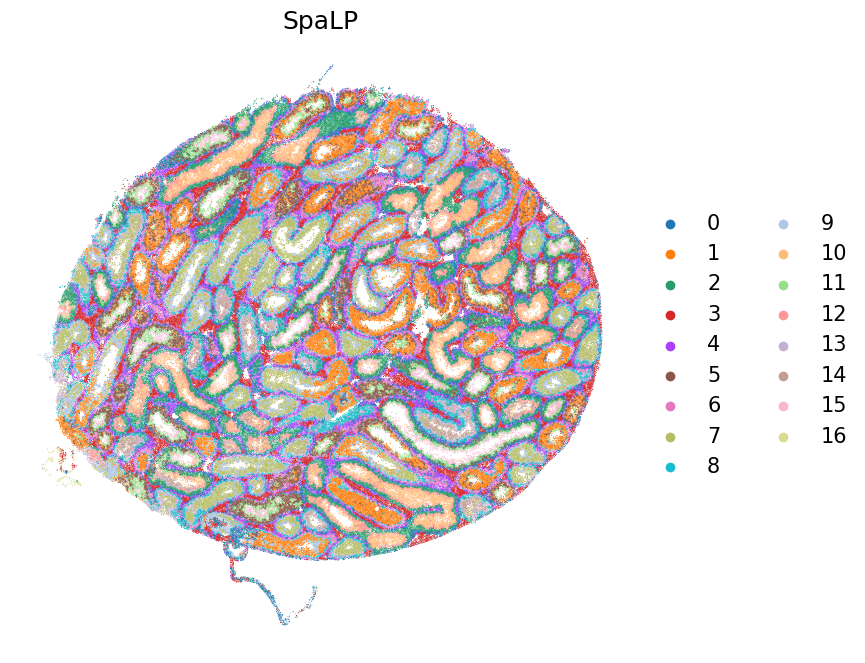

In [49]:
adata.obsm['spatial'][:, 1] = -adata.obsm['spatial'][:, 1]
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['font.size'] = 15
sc.pl.embedding(adata,color='SpaLP',basis='spatial',s=3,title='SpaLP',frameon=False)

## <span style="color:black; font-weight:bold;">Spatial mapping of original gene expression</span>

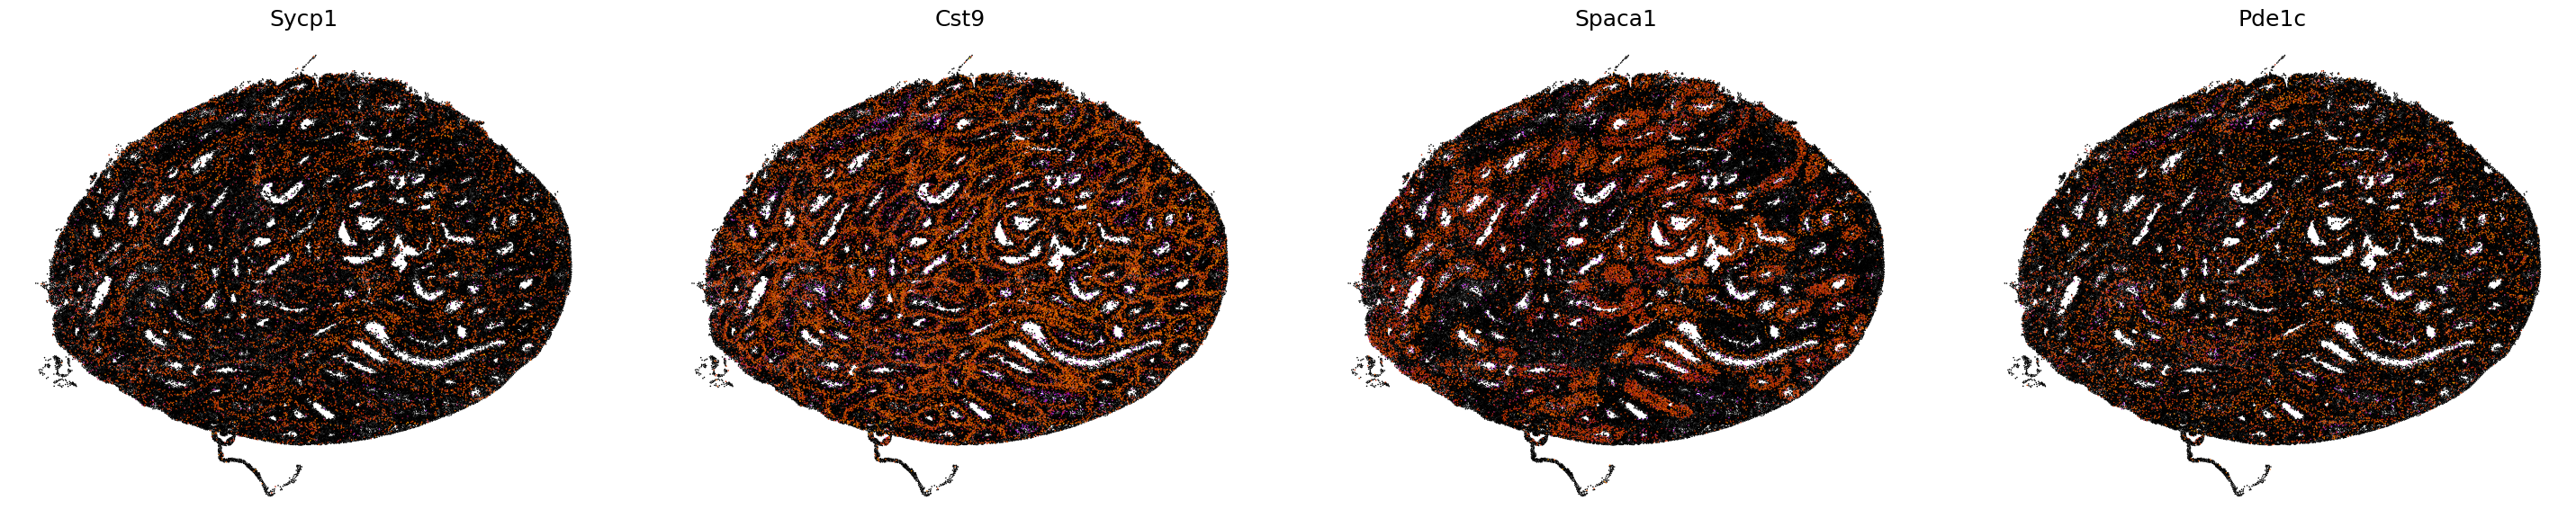

In [47]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (8,7)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata,color=['Sycp1','Cst9','Spaca1','Pde1c'],basis='spatial',s=5,frameon=False,colorbar_loc=None,cmap='gnuplot')

## <span style="color:black; font-weight:bold;">Spatial mapping of reconstructed gene expression</span>

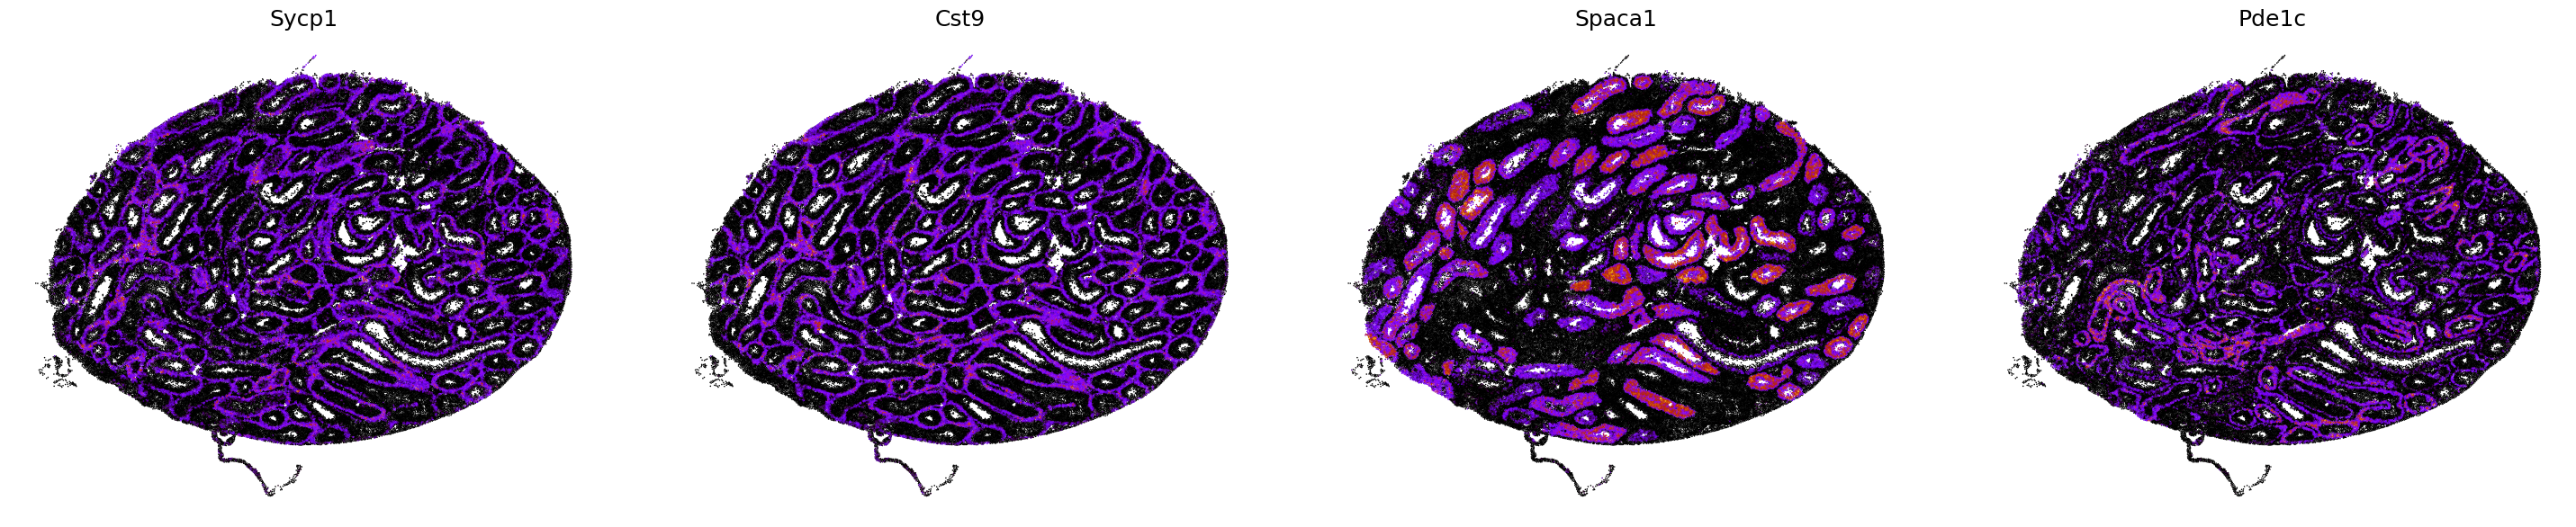

In [46]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (8,7)
plt.rcParams['font.size'] = 15

sc.pl.embedding(adata2,color=['Sycp1','Cst9','Spaca1','Pde1c'],basis='spatial',s=5,frameon=False,colorbar_loc=None,cmap='gnuplot')